# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_iters, plot_coverage_all
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

### Example 4: Portfolio management


In [2]:
n = 2
N=5000
seed = 15
np.random.seed(seed)
dist = (np.array([25, 10, 60, 50, 40, 30, 30, 20,
        20, 15, 10, 10, 10, 10, 10, 10])/10)[:n]
dist = (np.array([10, 10, 60, 50, 40, 30, 30, 20,
        20, 15, 10, 10, 10, 10, 10, 10])/10)[:n]
num_scenarios = 10
y_data = np.random.dirichlet(dist,num_scenarios)
# y_data = np.maximum(y_nom + np.random.normal(0,0.2,(num_scenarios,n)),0.001)
# y_data = np.diag(1/np.sum(y_data, axis=1))@y_data
num_reps = int(N/10)
y_data = np.vstack([y_data]*num_reps)

In [3]:
def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.5, -0.3], [-0.3, 0.4]])
    mu = np.array((0.3, 0.3))
    d_train = np.random.multivariate_normal(mu, sig, N)
    # d_train = np.exp(d_train)
    return d_train

data = gen_demand_intro(N, seed=15)


In [4]:
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data))
# u = lropt.UncertainParameter(n,
#                         uncertainty_set=lropt.MRO(p=2,train=True,K=5,
#                                                     data=data))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
y = lropt.Parameter(n, data=y_data)

objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
eval_exp = -x @ u + 0.2*cp.norm(x-y, 1)
prob = lropt.RobustProblem(objective, constraints, eval_exp = eval_exp)
test_p = 0.9
s = 5
train, test = train_test_split(data, test_size=int(
    data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(np.cov(train.T))
init_bval = np.mean(train, axis=0)
np.random.seed(15)
initn = np.random.rand(n,2)
init_bvaln = np.mean(train, axis=0)
# Train A and b
result = prob.train(lr=0.001, train_size = False, num_iter=300, optimizer="SGD",seed=8, init_A=initn, init_b=init_bvaln, init_lam=1, init_mu=1,
                    mu_multiplier=1.001, kappa=0., init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 50, lr_gamma = 0.5, random_init = False, num_random_init = 5, parallel = False, position = False, eta=0.05,contextual = True)
df = result.df
A_fin = result.A
b_fin = result.b

In [5]:
# Grid search epsilon
eps_list = np.linspace(0.0001, 4, 10)
result4 = prob.grid(epslst=eps_list, init_A=init,
                    init_b=init_bval, seed=8,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
dfgrid = result4.df

result5 = prob.grid(epslst=eps_list, init_eps = result.eps, init_A=A_fin, init_b=b_fin, seed=8,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6), contextual = True, linear = result._linear)
dfgrid2 = result5.df

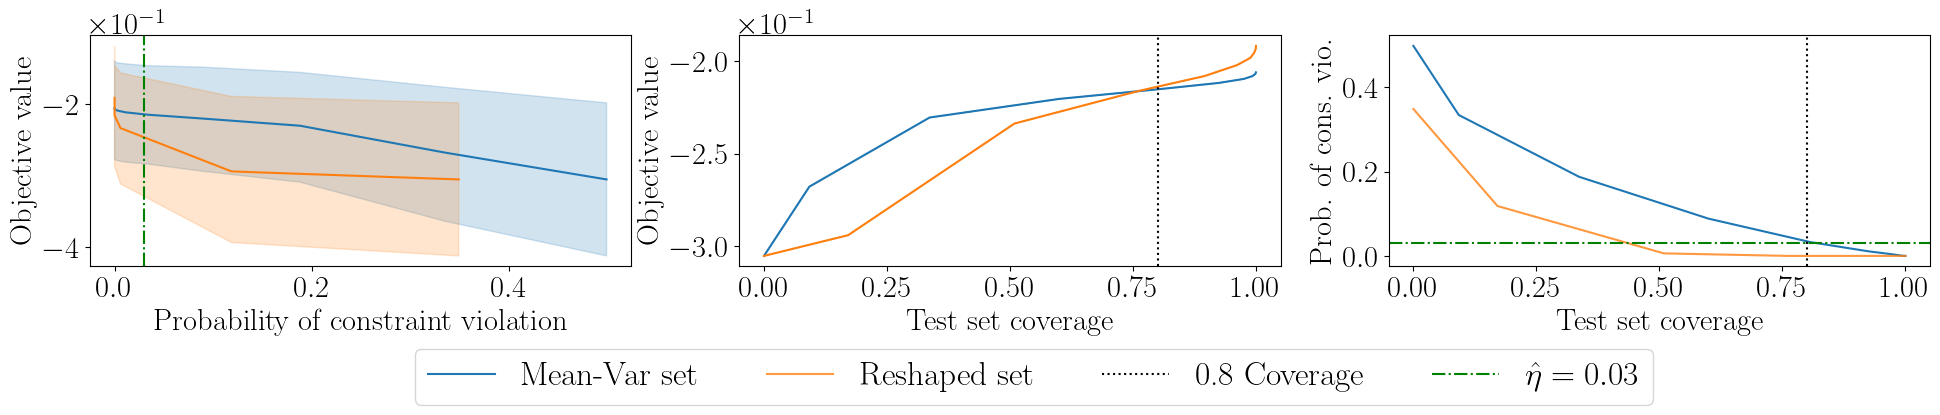

In [6]:
plot_coverage_all(dfgrid,dfgrid2,None, "Portlinear8",ind_1=(0,500),ind_2=(0,500), logscale = False, zoom = False,legend = True)

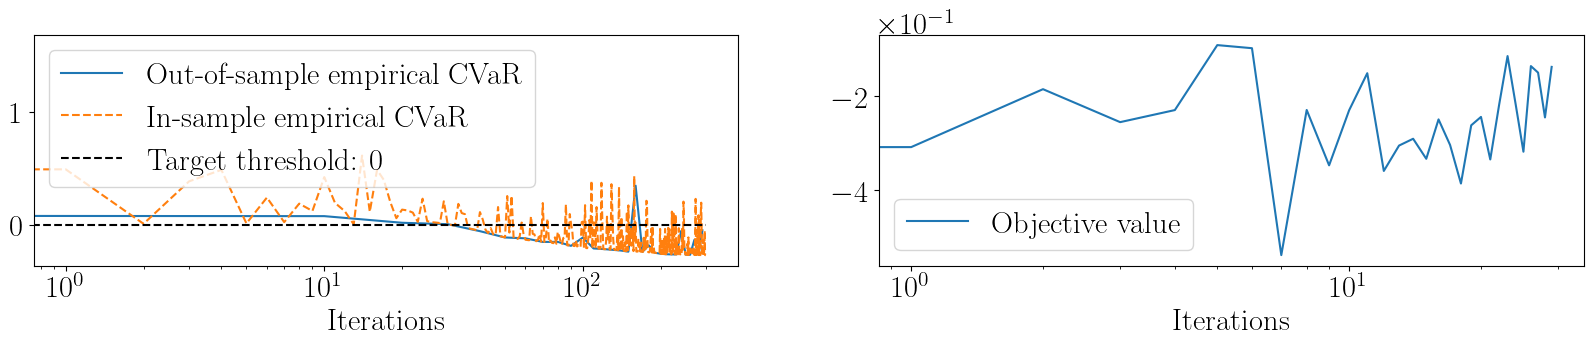

In [7]:
plot_iters(df, result.df_test, "Port", steps = 20000,logscale = 1)

In [8]:
prob_list = np.array([0.,0.01,0.05,0.1])
# prob_list = np.linspace(0,0.5,10)
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
st_eps = eps_list[inds_standard[0]]
re_eps = eps_list[inds_reshaped[0]]
st_eps, re_eps
# A_fin = initn
# b_fin = init_bvaln

(3.5555666666666665, 1.3334)

In [9]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
test_val_st = []
prob_val_st = []
test_val_re = []
prob_val_re = []
t_re = []
t_st = []
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(10):
        n = 2
        Amat = result._a_history[-1][scene]*result.eps
        bvec = result._b_history[-1][scene]
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2, dimension=2, rho=eps_list[inds_reshaped[ind]], a = Amat, b =bvec))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = y_data[scene]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]
        # constraints += [x == x_opt_base[ind][scene]]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        test_val_re.append(np.mean(-test@x.value) + 0.2*np.linalg.norm(x.value-p.value,1))
        prob_val_re.append(np.sum(np.where(np.maximum(-test@x.value - t.value,0)>= 0.001,1,0))/60)
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x.value
        t_re.append(t.value)
        t_learned[ind][scene] = t.value

        n = 2
        Amat = (eps_list[inds_standard[ind]])*init
        bvec = init_bval
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,dimension = 2,a = Amat, b = bvec))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = y_data[scene]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        test_val_st.append(np.mean(-test@x.value) + 0.2*np.linalg.norm(x.value-p.value,1))
        prob_val_st.append(np.sum(np.where(np.maximum(-test@x.value - t.value,0)>= 0.001,1,0))/60)
        t_st.append(t.value)
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x.value
        t_base[ind][scene] = t.value

        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
Amat, bvec, init, init_bval

(array([[ 0.91849495, -0.31929892],
        [-0.31929892,  0.78443187]]),
 array([0.28139895, 0.33037482]),
 array([[ 0.68883677, -0.23946221],
        [-0.23946221,  0.58829449]]),
 array([0.28139895, 0.33037482]))

In [10]:
np.mean(test_val_re[10:]),np.mean(test_val_st[10:])

(-0.27185106231306216, -0.2143251139991982)

In [11]:
K =num_scenarios
Amat = result._a_history[-1]*result.eps
bvec = result._b_history[-1]
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
                # np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)
                # fin_set[ind][k_ind][i,j] = np.linalg.norm((1/inds_reshaped[ind])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/inds_reshaped[ind])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*(init.T@np.linalg.inv(init@init.T))@(u_vec  - init_bval))

                # np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
            
            for scene in range(10):
                g_level_learned[ind][scene][i,j] = -x_opt_learned[ind][scene]@u_vec - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = -x_opt_base[ind][scene]@u_vec - t_base[ind][scene]

In [14]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(500,size=200,replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0][newtrain],train[:,1][newtrain], color = "white",edgecolor = "black")
        axis.scatter(np.mean(test,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')

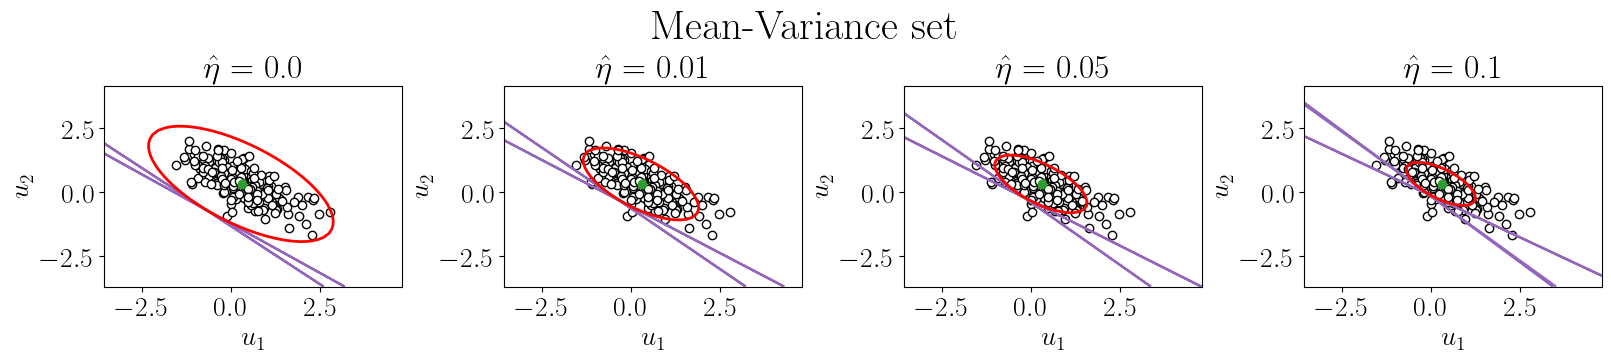

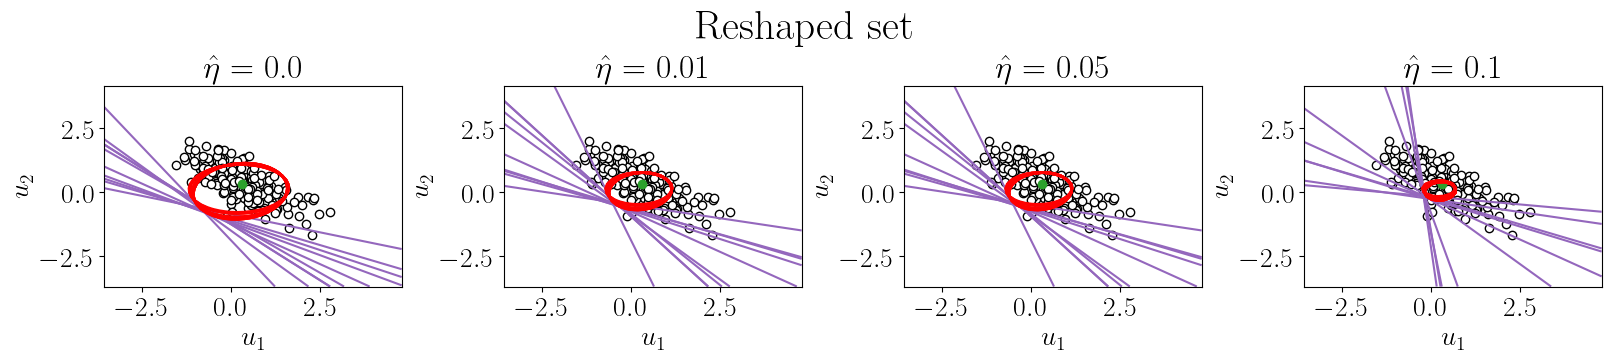

In [15]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,10,train, "port_intro_new",standard = True, K=1) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,10,train, "port_intro_new",standard = False, K=10)

### GIF

In [16]:
A_fin = result.A 
b_fin = result.b
A1_iters, b1_iters = result.uncset_iters
eps_iters = result._eps_history

def port_prob(A_final, b_final, scene, contextual):
    n = 2
    if contextual:
        u = lropt.UncertainParameter(n,
                                    uncertainty_set=lropt.Ellipsoidal(p=2, a = A_final[scene], b =b_final[scene]))
    else:
        u = lropt.UncertainParameter(n,
                                    uncertainty_set=lropt.Ellipsoidal(p=2, a = A_final, b =b_final))
    # Formulate the Robust Problem
    x = cp.Variable(n)
    t = cp.Variable()
    p = cp.Parameter(n)
    p.value = y_data[scene]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

    constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]
    # constraints += [x == x_opt_base[ind][scene]]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    t_opt = t.value
    x_opt = x.value
    return x_opt, t_opt

offset = 1
x_min, x_max = np.min(train[:,0]) - 3*offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def optimal_sols(A_final, b_final, num_scenarios, contextual):
    x_opt = {}
    t_opt = {}
    for scene in range(num_scenarios):
        x_opt[scene], t_opt[scene] = port_prob(A_final, b_final, scene, contextual)
    return x_opt, t_opt

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh, contextual = False):
    if not contextual:
        unc_level_set = np.zeros((n,n))
    else:
        unc_level_set = np.zeros((num_scenarios,n,n))
    g_level_set = np.zeros((num_scenarios,n,n))
    x_opt,t_opt = optimal_sols(A_final, b_final, num_scenarios, contextual)
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            for scene in range(num_scenarios):
                if contextual:
                    unc_level_set[scene,i,j] = np.linalg.norm((A_final[scene].T@np.linalg.inv(A_final[scene]@A_final[scene].T)) @ (u_vec  - b_final[scene]))
                else:
                    unc_level_set[i,j] = np.linalg.norm((A_final.T@np.linalg.inv(A_final@A_final.T)) @ (u_vec  - b_final))
                g_level_set[scene,i,j] = -x_opt[scene]@u_vec - t_opt[scene]

    return unc_level_set, g_level_set

unc_level_learned, g_level_learned = level_set(A1_iters[-1]*eps_iters[-1]*re_eps, b1_iters[-1], contextual = True)
unc_level, g_level = level_set(A1_iters[1]*eps_iters[1]*re_eps, b1_iters[1], contextual = True)
unc_level_base, g_level_base = level_set(init*st_eps, init_bval, contextual = False)

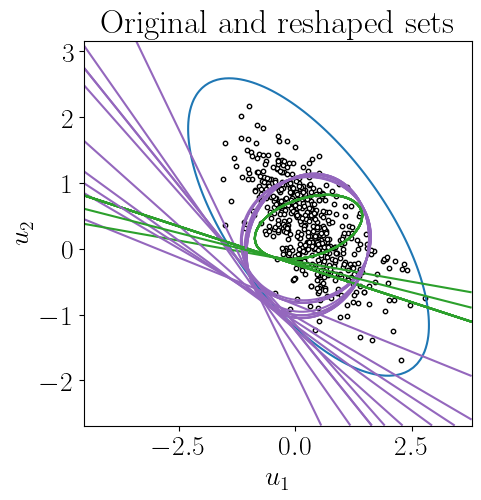

In [17]:
plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
for scene in range(10):
    plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:purple"], label = "Final Set")
    plt.contour(x_mesh,y_mesh,g_level_learned[scene,:,:], [0], colors = ["tab:purple"], label = "Final Set")
    plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:green"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [0], colors = ["tab:green"], label = "Initial Set")

plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

In [29]:
import os
import imageio

newpath = "gif_images/"
if not os.path.exists(newpath):
    os.makedirs(newpath)    
newpath = "gifs/"
if not os.path.exists(newpath):
    os.makedirs(newpath)   

filenames = []
eps_train = np.linspace(1,re_eps, 80)
# inds = np.hstack([np.arange(20,step=2), np.arange(22,400,step=5)])
inds = np.hstack([np.arange(1,300,step=5),300])
for i in range(len(inds)):
    ind = inds[i]
    unc_level, g_level = level_set(A1_iters[ind]*eps_iters[ind]*re_eps, b1_iters[ind], contextual = True)
    # if i < 10:
    #     unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    # elif i < 20:
    #     unc_level, g_level = level_set(A1_iters[10+9*(i-10)], b1_iters[10+9*(i-10)])
    # else:
    #     unc_level, g_level = level_set(A1_iters[99]/eps_train[i-20], b1_iters[99]/eps_train[i-20])
    plt.figure(figsize=(5, 5))
    plt.title("Aug. Lag: {}".format(np.round(df["Lagrangian_val"].iloc[ind-1],3)))
    # Set axis label for the contour plot
    # plt.xlabel(r"$u_1$")
    # plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")

    for scene in range(1):
        plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:red"], label = "trained Set")
        plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:green"], label = "Final Set")
        plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [0], colors = ["tab:purple"], label = "Initial Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/portfolio5.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

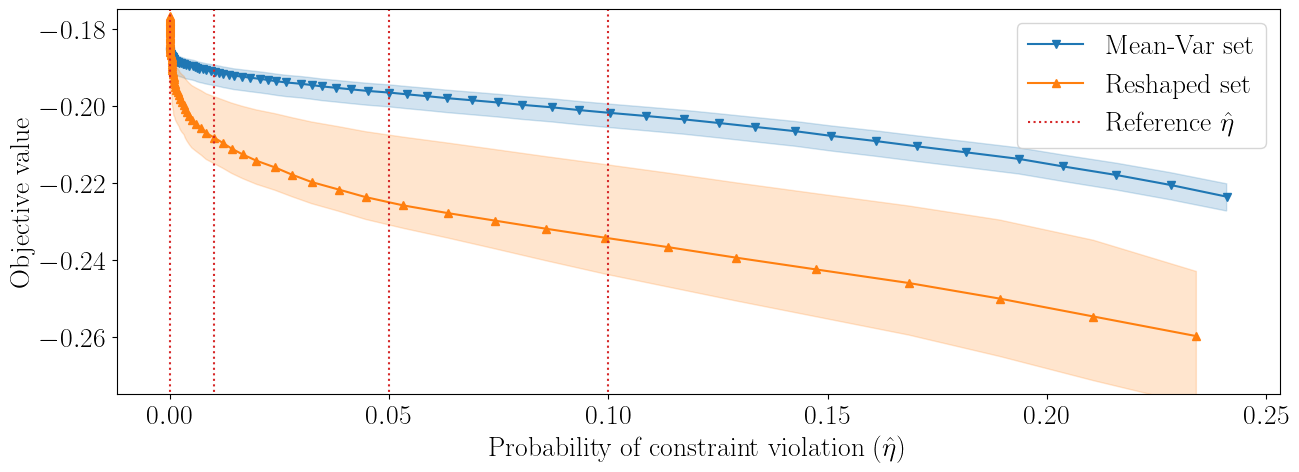

In [662]:
beg1, end1 = 17, 100
beg2, end2 = 15, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Avg_prob_test'][beg1:end1],dfgrid['Avg_prob_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
# for ind in range(4):
#     plt.scatter(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
#         dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Avg_prob_test'][beg2:end2],dfgrid2['Avg_prob_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
# for ind in [0, 2, 1, 3]:
#     plt.scatter(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[inds_reshaped[ind]], np.mean(
#         np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
# plt.ylim([-3, 1])
minv, maxv = (-0.25,-0.1)
minv, maxv = (-0.28,-0.17)
plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
           color="tab:red", label="Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
plt.legend(loc="upper right")
plt.ylim([-0.275,-0.175])
plt.savefig("portlinear_objective_vs_violations_new.pdf", bbox_inches='tight')

In [5]:
t = np.zeros((25,10))
t[0] = np.array([0.1201, 0.0807, 0.1087, 0.1251, 0.0692, 0.0957, 0.1311, 0.0949, 0.0791,
         0.0954])
t[1] = [0.1208, 0.0800, 0.1087, 0.1260, 0.0682, 0.0956, 0.1322, 0.0948, 0.0784,
         0.0952]
t[2] = [0.1344, 0.0696, 0.1087, 0.1426, 0.0621, 0.0943, 0.1345, 0.0930, 0.0670,
         0.0937]
t[3] = [0.1364, 0.0678, 0.1087, 0.1452, 0.0621, 0.0940, 0.1345, 0.0927, 0.0651,
         0.0934]
t[4] = [ 0.1379, 0.0666, 0.1087, 0.1470, 0.0621, 0.0938, 0.1345, 0.0924, 0.0637,
         0.0932]
t[5] = [0.1414, 0.0636, 0.1087, 0.1513, 0.0621, 0.0933, 0.1345, 0.0918, 0.0606,
         0.0926]
t[6] = [0.1434, 0.0620, 0.1087, 0.1537, 0.0621, 0.0931, 0.1345, 0.0914, 0.0588,
         0.0923]
t[7] = [ 0.1455, 0.0601, 0.1087, 0.1564, 0.0621, 0.0928, 0.1345, 0.0911, 0.0568,
         0.0920]
t[8] = [0.1479, 0.0581, 0.1087, 0.1594, 0.0621, 0.0924, 0.1345, 0.0906, 0.0546,
         0.0916]
t[9] = [ 0.1506, 0.0558, 0.1087, 0.1627, 0.0621, 0.0920, 0.1345, 0.0902, 0.0521,
         0.0912]
t[10] = [ 0.1537, 0.0533, 0.1087, 0.1665, 0.0621, 0.0916, 0.1345, 0.0896, 0.0493,
         0.0907]
t[11] = [ 0.1571, 0.0504, 0.1087, 0.1707, 0.0621, 0.0911, 0.1345, 0.0890, 0.0462,
         0.0901]
t[12] = [0.1610, 0.0471, 0.1087, 0.1755, 0.0621, 0.0906, 0.1345, 0.0883, 0.0426,
         0.0895]
t[13] = [0.1655, 0.0433, 0.1087, 0.1811, 0.0621, 0.0900, 0.1345, 0.0875, 0.0384,
         0.0888]
t[14] = [ 0.1703, 0.0385, 0.1087, 0.1871, 0.0621, 0.0888, 0.1345, 0.0862, 0.0361,
         0.0876]
t[15] = [ 0.1753, 0.0326, 0.1087, 0.1935, 0.0621, 0.0871, 0.1345, 0.0843, 0.0361,
         0.0858]
t[16] = [ 0.1814, 0.0254, 0.1087, 0.2013, 0.0621, 0.0850, 0.1345, 0.0819, 0.0361,
         0.0835]
t[17] = [0.1888, 0.0166, 0.1087, 0.2108, 0.0621, 0.0824, 0.1345, 0.0790, 0.0361,
         0.0808]
t[18] = [0.1982, 0.0056, 0.1087, 0.2228, 0.0621, 0.0792, 0.1345, 0.0754, 0.0361,
         0.0774]
t[19] = [0.2077, 0.0010, 0.1087, 0.2354, 0.0621, 0.0736, 0.1345, 0.0693, 0.0361,
         0.0716]
t[20] = [0.2185, 0.0010, 0.1087, 0.2501, 0.0621, 0.0654, 0.1345, 0.0605, 0.0361,
         0.0631]
t[21] = [0.2347, 0.0010, 0.1087, 0.2572, 0.0621, 0.0580, 0.1345, 0.0523, 0.0361,
         0.0553]
t[22] = [0.2583, 0.0010, 0.1087, 0.2572, 0.0615, 0.0508, 0.1345, 0.0441, 0.0361,
         0.0477]
t[23] = [0.2951, 0.0010, 0.1087, 0.2572, 0.0546, 0.0415, 0.1345, 0.0334, 0.0361,
         0.0377]
t[24] = [0.3526, 0.0010, 0.1087, 0.2572, 0.0399, 0.0228, 0.1345, 0.0122, 0.0361,
         0.0349]

etas = np.array([5e-05, 0.0001, 0.00455, 0.00665,0.0092, 0.01335,0.0173, 0.02195, 0.0271, 0.034, 0.0419,0.0503, 0.06005, 0.0723, 0.0852, 0.1004, 0.11465,0.133,0.15205,0.17165,0.19375,0.2158,0.24065,0.2701,0.30225])


In [6]:
zipped = zip(etas,t)
newzipped = sorted(zipped)
sorted_etas = [z[0] for z in newzipped]
sorted_t = np.vstack([z[1] for z in newzipped])
np.random.seed(1)
mu = np.random.uniform(0.5,1,10)
F = np.random.normal(size = (10,2))
sig = 0.1*F@(F.T)
dist = mu
# y_data = np.random.dirichlet(dist, 10)
y_nom = np.random.dirichlet(dist,10)
zipped = zip(y_nom[0],sorted_t.T)
newzipped=sorted(zipped)
sorted_t2 = np.vstack([z[1] for z in newzipped])
y_sorted = np.hstack([z[0] for z in newzipped])
sorted_t2 = sorted_t2.T


In [16]:
mus = np.array([0.71, 0.86, 0.50, 0.65, 0.57, 0.55, 0.59, 0.67, 0.70, 0.77])
diags = np.array([0.36, 0.02, 0.64, 0.06, 0.25,  0.08,  0.03, 0.25, 0.11, 0.13])
zipped = zip(mus,diags)
sorted_zipp = sorted(zipped)
newmus = [z[0] for z in sorted_zipp]
newdiags = [z[1] for z in sorted_zipp]
print(newmus,newdiags)

[0.5, 0.55, 0.57, 0.59, 0.65, 0.67, 0.7, 0.71, 0.77, 0.86] [0.64, 0.08, 0.25, 0.03, 0.06, 0.25, 0.11, 0.36, 0.13, 0.02]


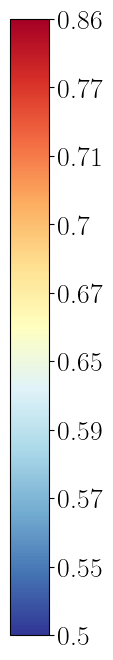

In [87]:
plt.figure(figsize=(0.5, 8))
tick_labels = newmus
tick_positions = [i/9 for i in range(10)]
img = plt.imshow(np.array([[1,0]]), cmap="RdYlBu_r")
plt.gca().set_visible(False)
cax = plt.axes()
cbar = plt.colorbar(orientation="vertical", cax=cax)
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
plt.savefig("colorbar_v.pdf", bbox_inches='tight')

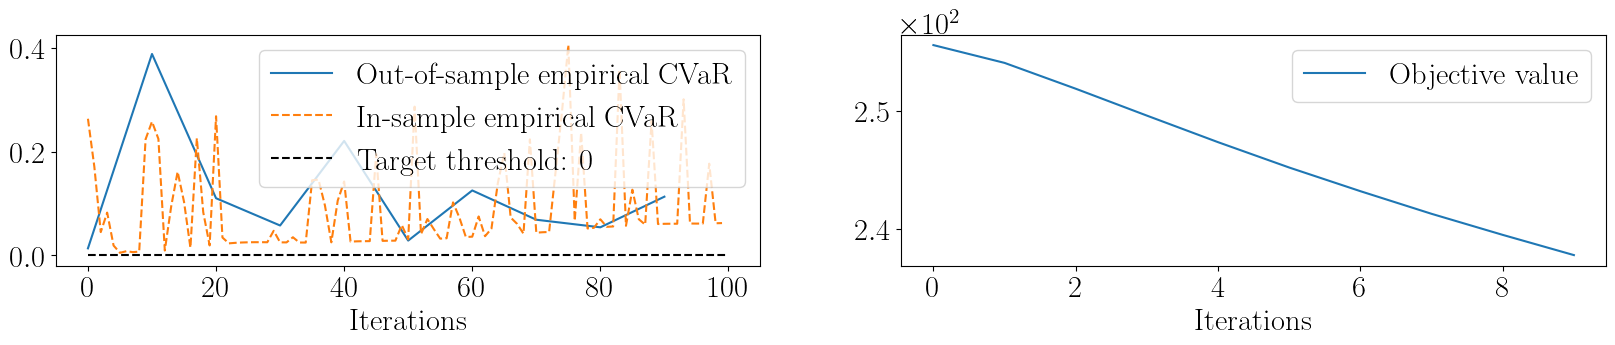

In [ ]:
plot_iters(result.df, result.df_test,"energy", logscale = False, steps = 1000)

In [40]:
newmus_norm = newmus/np.sum(newmus)

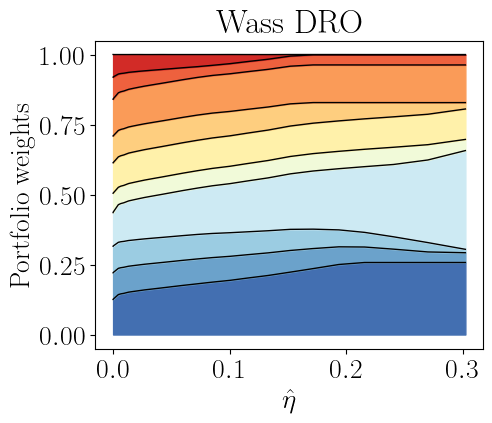

In [71]:
plt.figure(figsize=(5,4))
for i in range(1, 11):
    plt.fill_between(etas, np.sum(sorted_t2[:, :i-1], axis=1), 
                       np.sum(sorted_t2[:, :i], axis=1),color=plt.cm.RdYlBu(1 - i/11))
    plt.plot(sorted_etas, np.sum(sorted_t2[:, :i], axis=1),
               color='black', linewidth=1.0)
plt.title("Wass DRO")
plt.xlabel(r"$\hat{\eta}$")
plt.ylabel("Portfolio weights")
plt.savefig("Wass-dis.pdf", bbox_inches='tight')

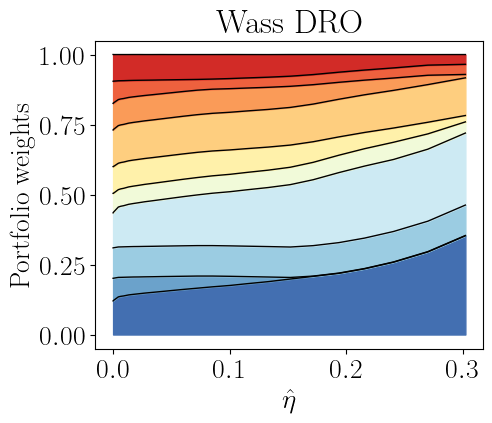

In [28]:
plt.figure(figsize=(5,4))
for i in range(1, 11):
    plt.fill_between(etas, np.sum(t[:, :i-1], axis=1), 
                       np.sum(t[:, :i], axis=1),color=plt.cm.RdYlBu(1 - i/11))
    plt.plot(sorted_etas, np.sum(t[:, :i], axis=1),
               color='black', linewidth=1.0)
plt.title("Wass DRO")
plt.xlabel(r"$\hat{\eta}$")
plt.ylabel("Portfolio weights")
plt.savefig("Wass-dis.pdf", bbox_inches='tight')

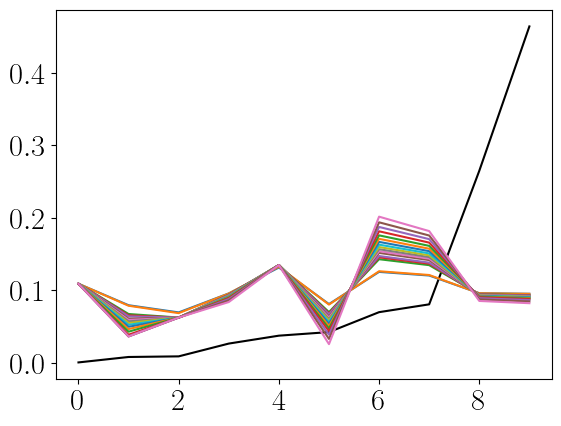

In [614]:
plt.plot(sorted(y_nom[0]), color = "black")
newt = [z[1] for z in sorted(zip(y_nom[0],t[9]))]
for i in range(17):
  plt.plot(sorted_t2[i])
# plt.plot(newt, color = "black")

In [ ]:
results_fin = {}
results_df = {}
results_grid = {}
seed = 15
for reps in range(5):
  y_data = np.random.dirichlet(dist,num_scenarios)
  num_reps = int(N/10)
  y_data = np.vstack([y_data]*num_reps)
  data = gen_demand_intro(N,reps+5)
  for etas in [0.05]:
    u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data))
    # u = lropt.UncertainParameter(n,
    #                         uncertainty_set=lropt.MRO(p=2,train=True,K=5,
    #                                                     data=data))
    # Formulate the Robust Problem
    x = cp.Variable(n)
    t = cp.Variable()
    y = lropt.Parameter(n, data=y_data)

    objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
    constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
    eval_exp = -x @ u + 0.2*cp.norm(x-y, 1)
    prob = lropt.RobustProblem(objective, constraints, eval_exp = eval_exp)
    test_p = 0.9
    s = 5
    train, test = train_test_split(data, test_size=int(
        data.shape[0]*test_p), random_state=s)
    # init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    # init_bval = -init@np.mean(train, axis=0)
    init = sc.linalg.sqrtm(np.cov(train.T))
    # init = np.reshape(newcov,(2,1))
    init_bval = np.mean(train, axis=0)
    np.random.seed(15)
    # initn = np.random.rand(n, n) + 0.1*init + 0.5*np.eye(n)
    # init_bvaln = -initn@(np.mean(train, axis=0) - 0.3*np.ones(n))
    # initn = np.random.rand(n, n) + 0.05*np.eye(n) + 0.01*init
    # init_bvaln = -initn@(np.mean(train, axis=0) - 0.3*np.ones(n))
    # np.random.seed(15)
    # initn = np.linalg.inv(0.8*(0.6*np.random.rand(n, n) + 0.3*np.eye(n)+ 0.01*init))
    # init_bvaln = np.mean(train, axis=0)
    initn = np.random.rand(n,2)
    init_bvaln = np.mean(train, axis=0)
    # Train A and b
    result = prob.train(lr=0.001, num_iter=300, optimizer="SGD",
                        seed=8, init_A=initn, init_b=init_bvaln, init_lam=0.5, init_mu=0.01,
                        mu_multiplier=1.001, kappa=-0.01, init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 100, lr_gamma = 0.2, random_init = True, num_random_init = 8, parallel = True, position = False, eta = etas)
    # result = prob.train(lr=0.01, num_iter=1, momentum=0.8, optimizer="SGD",
    #                     seed=s, init_A=init, init_b=init_bval, init_lam=0.5, init_mu=0.01,
    #                     mu_multiplier=1.001, init_alpha=0., test_percentage = test_p)
    df = result.df
    A_fin = result.A
    b_fin = result.b
    results_fin[(reps,etas)] = (A_fin,b_fin)
    results_df[(reps,etas)] = df
    # Grid search epsilon
    eps_list = np.linspace(0.0001, 4, 30)
    result4 = prob.grid(epslst=eps_list, init_A=init,
                        init_b=init_bval, seed=8,
                        init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
    dfgrid = result4.df
    result5 = prob.grid(epslst=eps_list, init_A=result.eps*A_fin, init_b=b_fin, seed=8,
                        init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6))
    dfgrid2 = result5.df
    results_grid[(reps,etas)] = (dfgrid,dfgrid2)


In [ ]:
results_grid_2 = {}
for reps in range(5):
  y_data = np.random.dirichlet(dist,num_scenarios)
  num_reps = int(N/10)
  y_data = np.vstack([y_data]*num_reps)
  data = gen_demand_intro(N,reps+5)
  for etas in [0.05]:
    u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data))
    x = cp.Variable(n)
    t = cp.Variable()
    y = lropt.Parameter(n, data=y_data)

    objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
    constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
    eval_exp = -x @ u + 0.2*cp.norm(x-y, 1)
    prob = lropt.RobustProblem(objective, constraints, eval_exp = eval_exp)
    test_p = 0.9
    s = 5
    train, test = train_test_split(data, test_size=int(
        data.shape[0]*test_p), random_state=s)
    np.random.seed(15)
    initn = np.random.rand(n,2)
    init_bvaln = np.mean(train, axis=0)
    eps_list = np.linspace(0.0001, 4, 100)
    result4 = prob.grid(epslst=eps_list, init_A=init,
                        init_b=init_bval, seed=8,
                        init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
    dfgrid = result4.df
    result5 = prob.grid(epslst=eps_list, init_A=results_fin[(reps,etas)][0], init_b=results_fin[(reps,etas)][1], seed=8,
                        init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6))
    dfgrid2 = result5.df
    results_grid_2[(reps,etas)] = (dfgrid,dfgrid2)

In [ ]:
dfgrid, dfgrid2 = results_grid_2[(0,0.05)]
dfgrid = dfgrid.drop(columns=["step","Probability_violations_test","var_values"])
dfgrid2 = dfgrid2.drop(columns=["step","Probability_violations_test","var_values"])
stacked = dfgrid["Test_val"]
stacked2 = dfgrid2["Test_val"]
for reps in range(1,5):
  newgrid, newgrid2 = results_grid_2[(reps,0.05)]
  newgrid = newgrid.drop(columns=["step","Probability_violations_test","var_values"])
  dfgrid = dfgrid.add(newgrid.reset_index(), fill_value=0)
  newgrid2 = newgrid2.drop(columns=["step","Probability_violations_test","var_values"])
  dfgrid2 = dfgrid2.add(newgrid2.reset_index(), fill_value=0)
  stacked = np.vstack([stacked,newgrid["Test_val"]])
  stacked2 = np.vstack([stacked2,newgrid2["Test_val"]])
dfgrid = dfgrid/5
dfgrid2 = dfgrid2/5
dfgrid["Lower_test"] = np.quantile(stacked,0.3,axis=0)
dfgrid["Upper_test"] = np.quantile(stacked,0.8,axis=0)
dfgrid2["Lower_test"] = np.quantile(stacked2,0.3,axis=0)
dfgrid2["Upper_test"] = np.quantile(stacked2,0.7,axis=0)
# dfgrid.to_csv("dfgrid")
# dfgrid2.to_csv("dfgrid2")
# dfgrid = pd.read_csv("dfgrid")
# dfgrid2 = pd.read_csv("dfgrid2")
# stacked = np.load("stacked.npy", allow_pickle=True)
# stacked2 = np.load("stacked2.npy", allow_pickle=True)
# dfgrid["Lower_test"] = np.quantile(stacked,0.3,axis=0)
# dfgrid["Upper_test"] = np.quantile(stacked,0.8,axis=0)
# dfgrid2["Lower_test"] = np.quantile(stacked2,0.3,axis=0)
# dfgrid2["Upper_test"] = np.quantile(stacked2,0.7,axis=0)